In [1]:
# 使用するライブラリのimport
import os
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


In [2]:
# 定数の宣言
IMAGES_PATH = "images"                                  # 生成画像の出力先フォルダ
DATA_PATH = "data/mnist"                                # テストデータフォルダ

EPOCHS = 100                                             # エポック数
BATCH_SIZE = 64                                          # バッチサイズ

LEARNING_RATE = 0.00005                                # 学習率

LATENT_DIM = 100                                        # 潜在変数（z)の次元数
IMG_SIZE = 28                                             # 画像の幅と高さ
CHANNELS = 1                                             # 画像のチャンネル数（１＝グレー）
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)             # イメージ画像（チャンネル、幅、高さ）

N_CRITIC = 5                                              # Gの学習ステップ（D / iter）
CLIP_VALUE = 0.01                                        # 重みのクリップ範囲
SAMPLE_INTERVAL = 50                                   # 生成画像サンプリングのタイミング

cuda = True if torch.backends.mps.is_available() else False          # GPUの利用チェック
print('GPU Check! gpu is ', cuda)


GPU Check! gpu is  True


In [40]:
# Generatorの定義
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [4]:
# Discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [5]:
# GeneratorとDiscriminatorのインスタンス化
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.to("mps")
    discriminator.to("mps")

# MNISTデータの読み込み
os.makedirs(DATA_PATH, exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        DATA_PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# 生成画像の出力フォルダの作成
os.makedirs(IMAGES_PATH, exist_ok=True)

In [6]:
# 最適化関数のセット
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [16]:
for i, (imgs, _) in enumerate(dataloader):
    print(i)
    print(imgs.shape)
    print("-------------")
    print(imgs)
    print(imgs.shape)
    print("-------------")
    print(_)
    
    break

0
torch.Size([64, 1, 28, 28])
-------------
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1.,

In [40]:
import torch
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image

# MPSデバイスが利用可能かどうかを確認
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# モデルをMPSデバイスに移動
generator.to(device)
discriminator.to(device)

# 学習のログ用リスト
img_list = []
G_losses = []
D_losses = []

batches_done = 0

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)

        # サンプルノイズの生成
        z = Variable(torch.randn(imgs.shape[0], LATENT_DIM, device=device))

        # 判定ラベル
        valid = Variable(torch.ones(imgs.shape[0], 1, device=device), requires_grad=False)
        fake = Variable(torch.zeros(imgs.shape[0], 1, device=device), requires_grad=False)
        #print(valid)
        #print(fake)

        # テスト画像
        real_imgs = Variable(imgs.type(torch.float))
        #print(real_imgs)

        # G(z)
        fake_imgs = generator(z)
        #print(fake_imgs)

        # ---------------------
        #  Discriminatorの学習
        # ---------------------
        optimizer_D.zero_grad()

        # D(x)とD(G(z))の敵対的損失
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        # 損失の誤差逆伝播
        loss_D.backward()
        optimizer_D.step()

        # 重みを一定の範囲にクリッピング
        for p in discriminator.parameters():
            p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

        if i % N_CRITIC == 0:
            # -----------------
            #  Generatorの学習
            # -----------------
            optimizer_G.zero_grad()

            # G(z)
            gen_imgs = generator(z)

            # D(G(z))の敵対的損失
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, EPOCHS, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )
            
            # ログ情報の収集
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        if batches_done % SAMPLE_INTERVAL == 0:
            save_image(fake_imgs.data[:25], IMAGES_PATH + "/%07d.png" % batches_done, nrow=5, normalize=True)
            img_list.append(fake_imgs.data[:25])

        batches_done += 1

        break

    break


tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
   

In [29]:
z.shape

torch.Size([32, 100])

In [36]:
for i , (imgs,_) in enumerate(dataloader):
    print(i)
    print(imgs.shape)
    print(imgs)
    print(_)
    break

0
torch.Size([64, 1, 28, 28])
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1

In [31]:
i

1876

In [32]:
len(imgs)

188

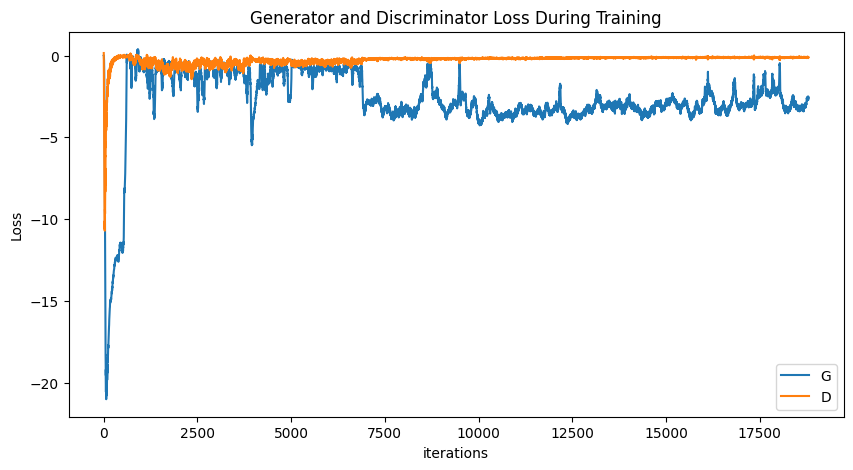

In [26]:
# 学習結果の可視化
import torchvision.utils as vutils
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 生成した画像をアニメーションGIFとして保存する
imgs = []
    
# 保存しているtorch.TensorをPil Imageに変換する
i = 0
for img in img_list :
  if(i%10) == 0:
      img_temp = vutils.make_grid(img, padding=2, nrow=5, normalize=True)
      imgs.append(transforms.functional.to_pil_image(img_temp))
  i += 1
    
imgs[0].save(
    "./Generator.gif", save_all=True, append_images=imgs[1:], duration=500, loop=0
)